Автор:     Шестаков Михаил Сергеевич  
Telegram:  https://t.me/mshestakov1  
email:     mikhail-shestakov-2022@bk.ru  

# Прогнозирование температуры звезды

**Содержание:**  
1. [Загрузка данных и общая информация](#section_1)  
 1.1. [Импорт библиотек](#section_1_1)  
 1.2. [Загрузка данных](#section_1_2)  
 1.3. [Общая информация](#section_1_2)  
    
    
2. [Предобработка данных](#section_2)  
 2.1. [Предобработка числовых значений](#section_2_1)  
 2.2. [Предобработка категориальных значений](#section_2_2)
 
 
3. [Исследовательский анализ данных](#section_3)  
 3.1. [Признак "star_type"](#section_3_1)  
 3.2. [Признак "star_color"](#section_3_2)  
 3.3. [Числовые признаки](#section_3_3)  


4. [Подготовка данных к построению нейросети](#section_4)  
 
5. [Построение базовой нейронной сети](#section_5)  

6. [Улучшение нейронной сети](#section_6)  

6. [Проверка на тестовой выборке](#section_7)  

7. [Общий вывод](#section_8)  

**Заказчик исследования:** обсерватории "Небо на ладони".  
**Цель исследования:** построить нейросеть, с помощью которой можно определить температуру на поверхности обнаруженных звёзд.


**Исходные данные:**  
Исходные данные представлены в датесете 6_class.csv;

В датасете содержатся следующие признаки:  
- Temperature (K) - абсолютная температура (температура на поверхности звезды в Кельвинах);
- Luminosity(L/Lo) — относительная светимость (светимость звезды относительно Солнца);
- Radius(R/Ro) - относительный радиус (радиус звезды относительно радиуса Солнца);
- Absolute magnitude(Mv) - абсолютная звёздная величина (физическая величина, характеризующая блеск звезды);
- Star type - тип звезды;
- Star color - звёздный цвет (цвет звезды, который определяют на основе спектрального анализа).

**Требования к качеству прогнозирования:** значение RMSE не должно превышать 4500.

## Загрузка данных и общая информация
<a id="section_1"></a>

### Импорт библиотек
<a id="section_1_1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import ydata_profiling

from functools import partial
from numpy import sqrt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline



from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.regressor import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring, EarlyStopping

from sklearn.utils import shuffle

C:\Users\bond_\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


### Загрузка данных
<a id="section_1_2"></a>

In [2]:
df = pd.read_csv('6_class.csv')

### Общая информация
<a id="section_1_3"></a>

In [3]:
# df.profile_report()

In [4]:
object_list = ['Star color']

def inf(df_info):
    print()
    print('Общая информация:')
    display(df_info.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Уникальные значения строковых признаков:')
    for i in object_list:
        print('{}:'.format(i))
        print(df_info[i].unique())
        print()
    print('Описательная статистика строковых значений:')
    display(df_info.describe(include='object').T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_info.describe().T)
    print('_' * 50)
    print()
    print('Процент пропущенных значений:')
    display(df_info.isna().mean()*100)
    print('_' * 50)
    print()
    print('Случайная выборка датафрейма:')
    display(df_info.sample(n = 5, random_state = 0))
    print('_' * 100)

In [5]:
inf(df)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 26.0 KB


None

__________________________________________________

Уникальные значения строковых признаков:
Star color:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']

Описательная статистика строковых значений:


,count,unique,top,freq
Star color,240,19,Red,112


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


__________________________________________________

Процент пропущенных значений:


Unnamed: 0                0.0
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
109,109,33421,352000.000,67.000,-5.79,4,Blue
71,71,3607,0.022,0.380,10.12,1,Red
37,37,6380,1.350,0.980,2.93,3,yellow-white
74,74,3550,0.004,0.291,10.89,1,Red
108,108,24345,142000.000,57.000,-6.24,4,Blue


____________________________________________________________________________________________________


1. В датафрейме 240 строк и 7 признаков. Признак "Unnamed: 0" - лишний: дублирует индексы датафрейма.
2. Пропущенные значения отсутствуют.  
3. Следующие признаки имеют тип int64:  
 - Unnamed: 0;  
 - Temperature (K);  
 - Star type.  
 
 Следующие признаки имеют тип object:  
  - Star color.   

 Следующие признаки имеют тип float64:  
  - Luminosity(L/Lo);   
  - Radius(R/Ro);   
  - Absolute magnitude(Mv).   
  
  
4. Уникальные значения признака "Star color" не в полной мере соответствуют <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>: вперемешку идет классификация по обычному описанию цвета и фактически видимому цвету.  
5. Максимальное значение признака "Temperature (K)" в 2.65 раз выше значения третьего квартиля.
6. Максимальное значение признака "Luminosity(L/Lo)" в 4.29 раз выше значения третьего квартиля.
7. Максимальное значение признака "Radius(R/Ro)" в 45.58 раз выше значения третьего квартиля.  
8. Максимальное значение признака "Absolute magnitude(Mv)" в 1.46 раз выше значения третьего квартиля.

## Предобработка данных
<a id="section_2"></a>

Удаляем признак "Unnamed: 0":

In [6]:
df = df.drop('Unnamed: 0', axis=1)

Приводим названия признаков в соответствие с требованиями PEP 8:

In [7]:
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Создаем списки категориальных и числовых значений:

In [8]:
cat_list = ['star_type', 'star_color']
num_list = ['luminosity', 'radius', 'temperature', 'absolute_magnitude']

### Предобработка числовых значений
<a id="section_2_1"></a>

Строим диаграммы размаха для числовых значений:

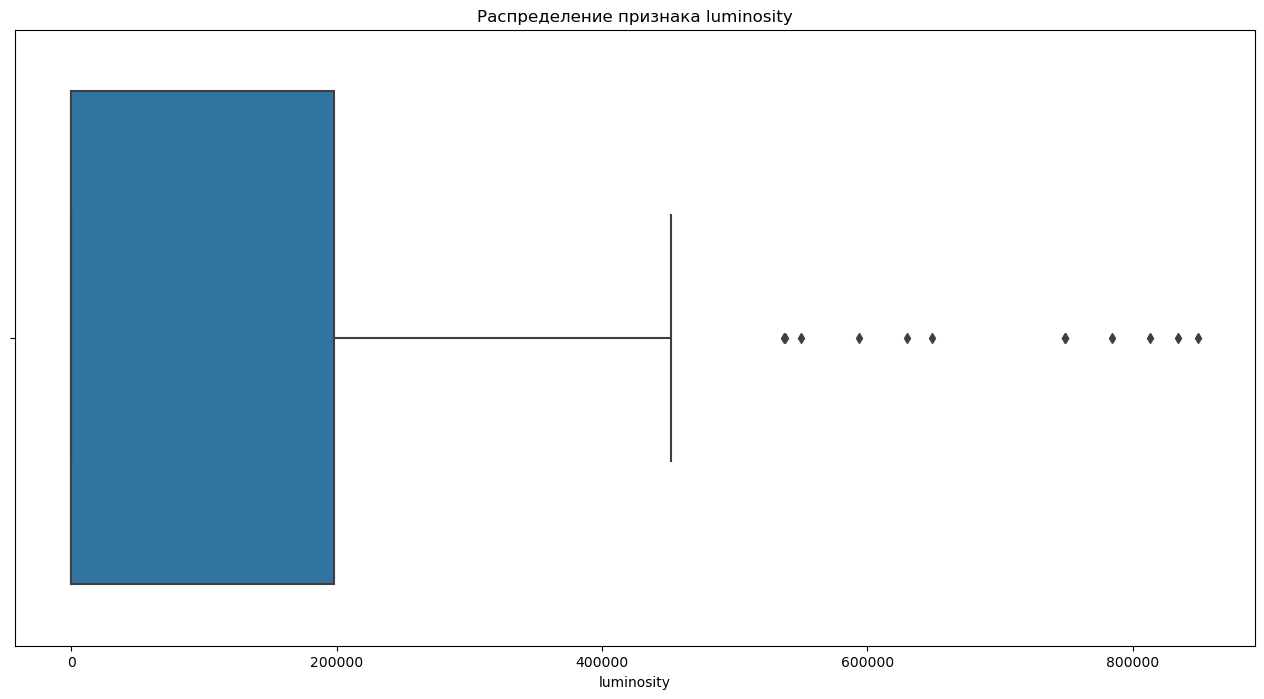

Минимальное значение - 8e-05, максимальное значение - 849420.0.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


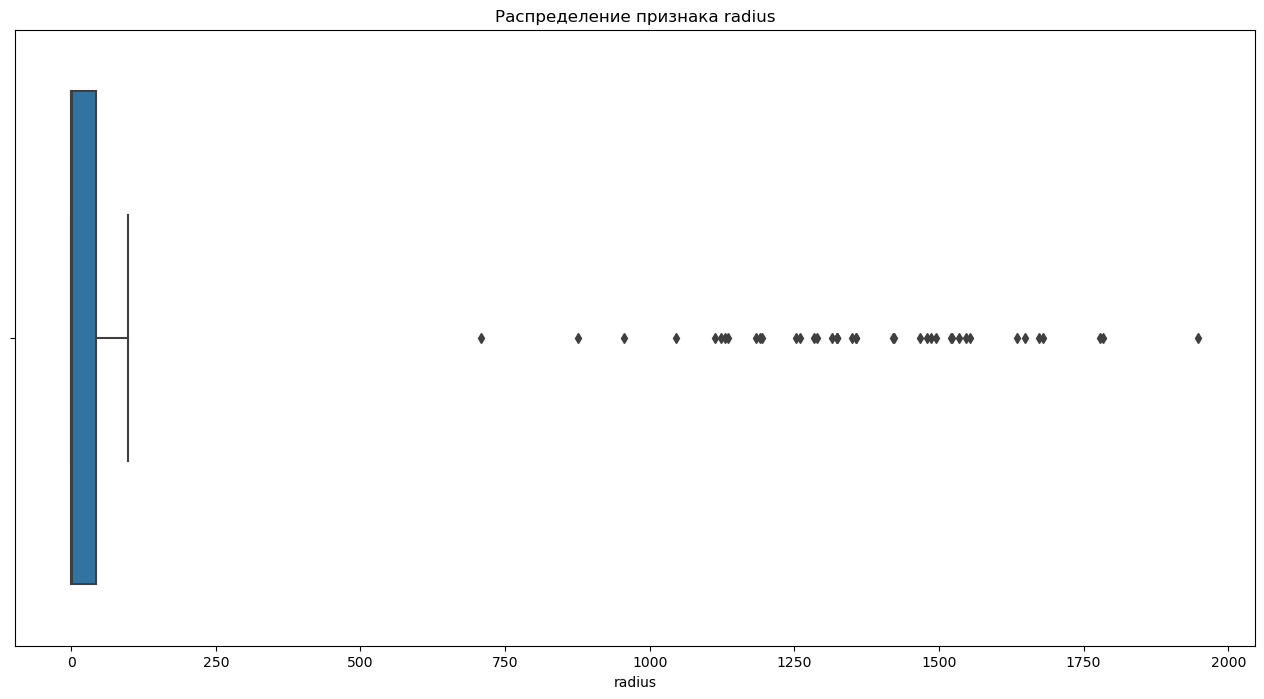

Минимальное значение - 0.0084, максимальное значение - 1948.5.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


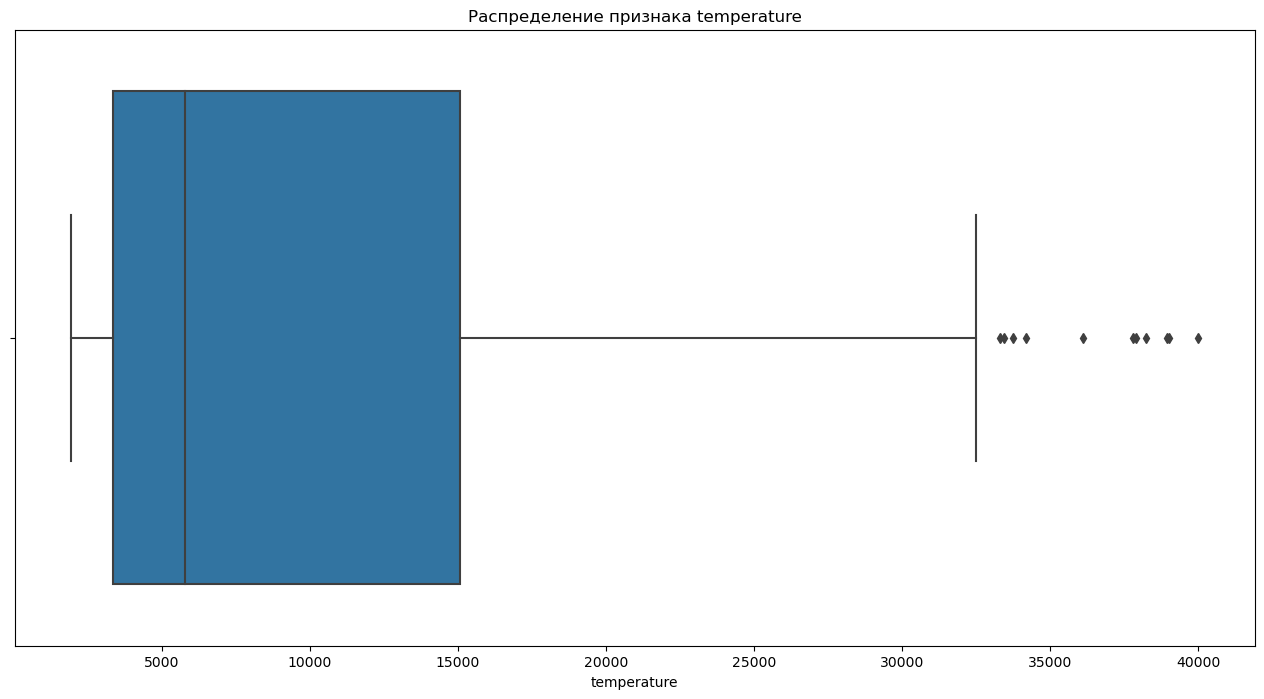

Минимальное значение - 1939, максимальное значение - 40000.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


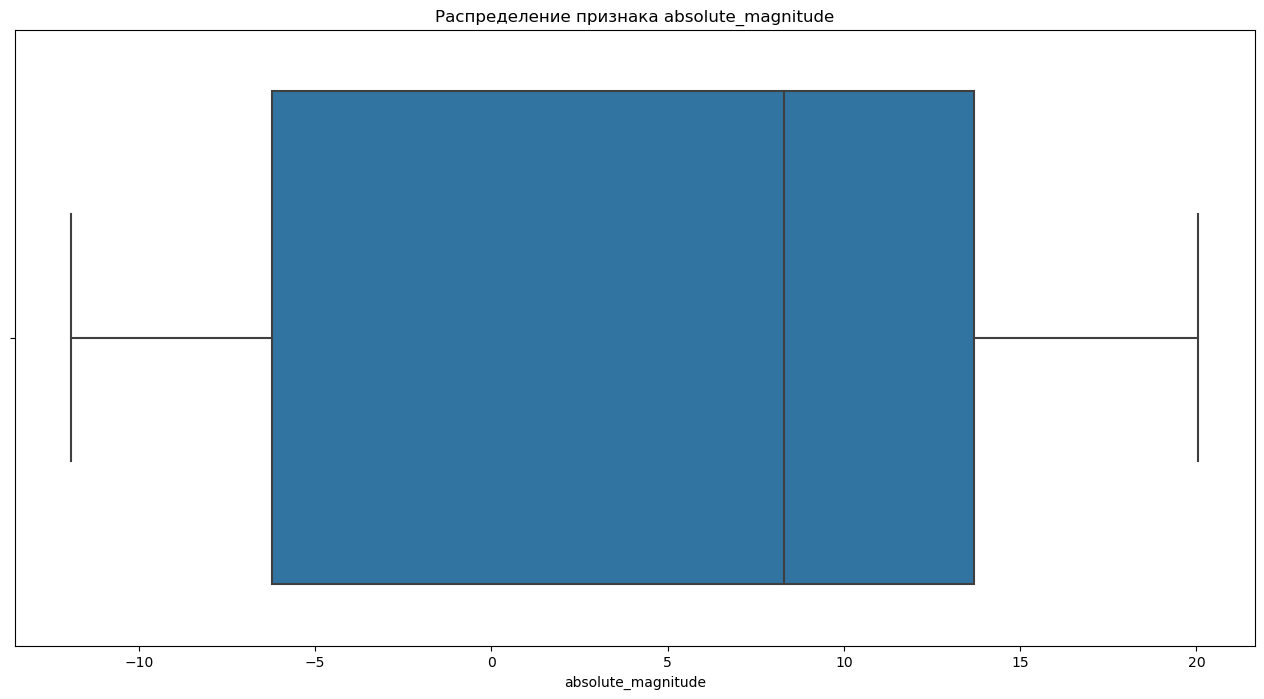

Минимальное значение - -11.92, максимальное значение - 20.06.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


In [9]:
for i in num_list:
    fig = plt.figure(figsize=(16,8))                               # создаем поле диаграммы
    ax1 = sns.boxplot(x=df[i])                                     # создаем диаграмму
    ax1 = plt.title('Распределение признака {}'.format(i))         # создаем заголовок диаграммы
    ax1 = plt.xlabel(i)                                            # подпись оси x
    plt.show()
    
    min_value = df[i].min()                                        # находим минимальное значение
    max_value = df[i].max()                                        # находим максимальное значение
    print('Минимальное значение - {}, максимальное значение - {}.'.format(min_value, max_value))
    print()
    print('_' * 100)
    print('_' * 100)

У числовых признаков "luminosity", "radius" и "temperature" все значения больше 0. Значения признака "absolute_magnitude" могут быть отрицательные, положительные и равные нулю.  
У признаков "luminosity", "radius" и "temperature" есть выбросы в большую сторону. Удалим из рассмотрении я объекты, если таковые имеются, у которых значения данных признаков превышают максимальные значения среди всех известных объектов:
- "luminosity" - максимальное значение 8710000 L/Lo (для звезды <a href="https://infogalactic.com/info/R136a1">R136</a>);
- "radius" - максимальное значение 1708±192 R/Ro (для звезды <a href="https://infogalactic.com/info/UY_Scuti">UY Scuti</a>);
- "temperature" - максимальное значение 210000 K (для звезды <a href="https://infogalactic.com/info/WR_102">WR 102</a>).

In [10]:
lum_max = 8710000
radius_max = 1708+192
temp_max = 210000

Проверяем объекты на аномальность признаков (значения выше максимальных):

In [11]:
param_dict = {'luminosity' : lum_max, 'radius' : radius_max, 'temperature' : temp_max}
for key, value in param_dict.items():
    anomal_cnt = df.loc[df[key] > value]
    print('Количество аномальных значений признака {} - {}.'.format(key, anomal_cnt.shape[0]))
    if anomal_cnt.shape[0] > 0:
        display(anomal_cnt)
    print('_' * 100)
    print('_' * 100)
    print()

Количество аномальных значений признака luminosity - 0.
____________________________________________________________________________________________________
____________________________________________________________________________________________________

Количество аномальных значений признака radius - 1.


,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
232,32489,648430.0,1948.5,-10.84,5,Blue


____________________________________________________________________________________________________
____________________________________________________________________________________________________

Количество аномальных значений признака temperature - 0.
____________________________________________________________________________________________________
____________________________________________________________________________________________________



В датафрейме 1 объект с признаком, превышающем значения соответственного признака всех официально зарегистрированных объектов. Относительный радиус объекта с индексом 242 на 2,5% превышает максимальный зарегестрированный.  
Поскольку обсерватория - научно-исследовательское учреждение, можно допускаем, что заказчик предполагает существование объекта с такими экстремальными параметрами, а значит не следует исключать его (объект) из исследования.

### Предобработка категориальных значений
<a id="section_2_2"></a>

***Признак "star_color"***

Приводим значения признака "star_color" к единой форме: убираем пробелы вначале и в конце строки, заменяем тире на пробелы и переводим в нижний регистр:

In [12]:
df['star_color'] = df.apply(lambda x: x['star_color'].strip().replace('-', ' ').lower(), axis=1)

Значения признака должны соответствовать приведенным в <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>:

In [13]:
class_list = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
temperature_list = ['≥ 30000', '10000–30000', '7500–10000', '6000–7500', '5200–6000', '3700–5200', '2400–3700']
conv_color_list = ['blue', 'blue white', 'white', 'yellow white', 'yellow', 'orange', 'red']
actual_apparent_list = ['blue', 'deep blue white', 'blue white', 'white', 'yellowish white',
                        'pale yellow orange', 'light orange red']
df_class = pd.DataFrame(list(zip(class_list, temperature_list, conv_color_list, actual_apparent_list)),
                        columns =['class', 'temperature', 'conventional_color_description', 'actual_apparent_color'])
df_class

,class,temperature,conventional_color_description,actual_apparent_color
0,O,≥ 30000,blue,blue
1,B,10000–30000,blue white,deep blue white
2,A,7500–10000,white,blue white
3,F,6000–7500,yellow white,white
4,G,5200–6000,yellow,yellowish white
5,K,3700–5200,orange,pale yellow orange
6,M,2400–3700,red,light orange red


В дата фрейме по цвету часть объектов классифицировано по "conventional_color_description" (по обычному описанию цвета), другая - по "actual_apparent_color" (фактически видимому цвету). Классифицируем все объекты по "actual_apparent_color". Для разных классов  значения "blue white" и "white" у "conventional_color_description" и "actual_apparent_color" совпадают. Значения "blue white" и "white", относящиеся к "conventional_color_description" пометим как "blue white_ccd" и "white_ccd" соответственно:

In [14]:
df.loc[(df['temperature'] > 10000) & (df['temperature'] <= 30000) & (df['star_color'] == 'blue white'), 'star_color'] = 'blue white_ccd'
df.loc[(df['temperature'] > 7500) & (df['temperature'] <= 10000) & (df['star_color'] == 'white'), 'star_color'] = 'white_ccd'

В датафрейме присутствует значение "whitish", которое отсутствует в <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>. Находим среднее значение температуры объектов "whitish" и по нему определяем класс, к которому они принадлежат:

In [15]:
whitish_temp = df.loc[(df['temperature'] > 7500) & (df['temperature'] <= 10000) & (df['star_color'] == 'whitish')]\
                    ['temperature'].mean()
print('Средняя температура звезд, классифицированных как "whitish" - {} K.'.format(whitish_temp))

Средняя температура звезд, классифицированных как "whitish" - 8876.0 K.


Согласно <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a> данные объекты откосятся к классу "blue white" ("actual_apparent_color").

Приводим значения к классификации по "actual_apparent_color":

In [16]:
df['star_color'] = df['star_color'].replace({'red' : 'light orange red',
                                             'blue white_ccd' : 'deep blue white',
                                             'white_ccd' : 'blue white',
                                             'whitish' : 'blue white',
                                             'yellow white' : 'white',
                                             'orange' : 'pale yellow orange',
                                             'white yellow' : 'white',
                                             'yellowish' : 'yellowish white',
                                             'orange red' : 'light orange red'})

Выводим список уникальных значений признака "star_color":

In [17]:
df['star_color'].unique()

array(['light orange red', 'deep blue white', 'blue white', 'white',
       'yellowish white', 'pale yellow orange', 'blue'], dtype=object)

***Признак "star_color"***

Выводим уникальные значения признака "star_type":

In [18]:
df['star_type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

Предобработка значений признака "star_type" не требуется.

**Вывод:**  
1. Названия признаков приведены в соответствие с требованиями PEP 8.
2. Обнаружен 1 объект с аномальным значением признака. Но из исследования он не исключен.
3. Значения признака "star_color" приведены к единой форме. Устранены разночтения в классификации объектов по данному признаку. Количество уникальных значений сокращено с 19 до 7.

## Исследовательский анализ данных
<a id="section_3"></a>

### Признак "star_type"
<a id="section_3_1"></a>

Выводим количество звезд по типу и строим гистограмму:

,star_type,star_count,percent
0,0,40,16.7
1,1,40,16.7
2,2,40,16.7
3,3,40,16.7
4,4,40,16.7
5,5,40,16.7


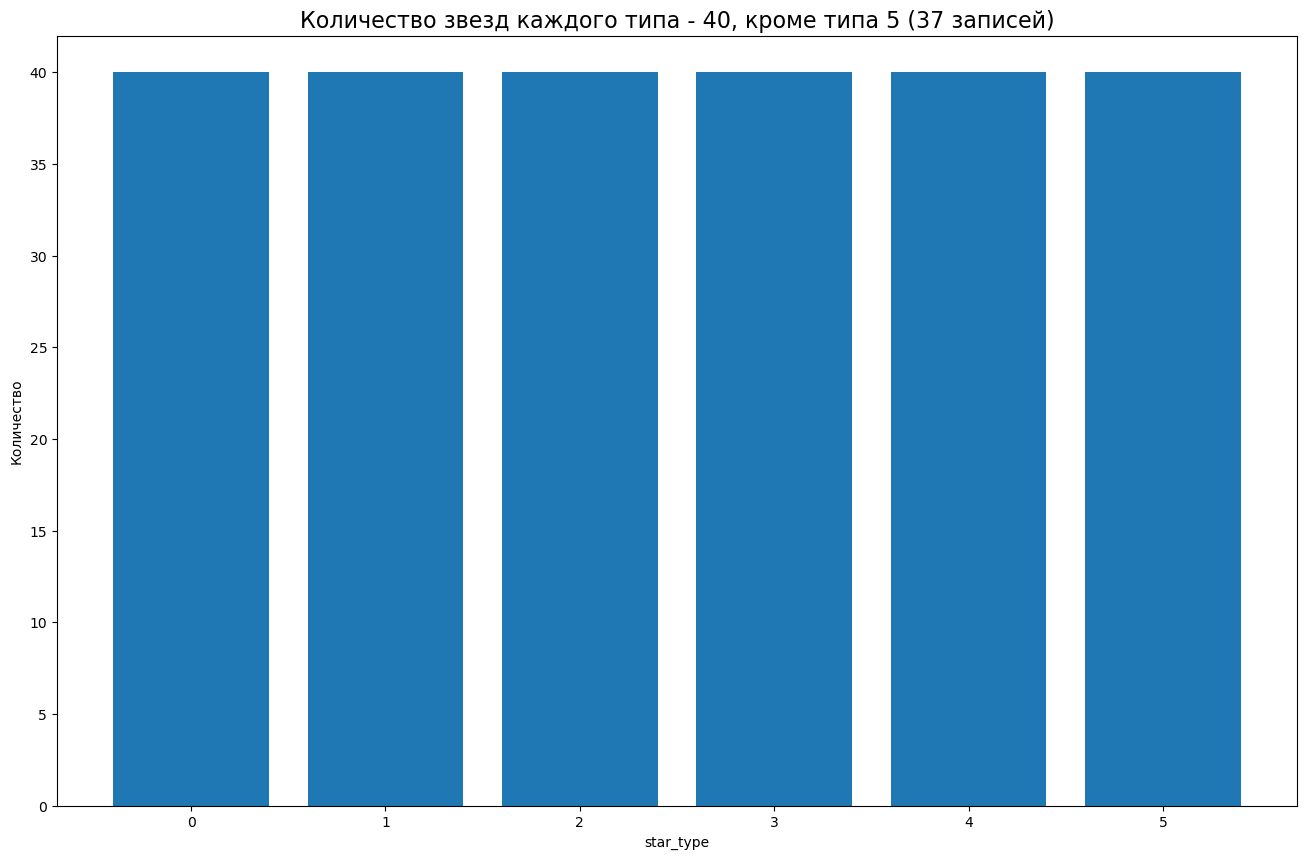

In [19]:
df_star_color = (
    df.groupby('star_type')['temperature']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns = {'temperature' : 'star_count'})
    .assign(percent=lambda x: (100 * x.star_count / df.shape[0]).round(1)) 
)
display(df_star_color)

df_star_color_sort = df_star_color.sort_values(by='star_count', ascending=True)
fig = plt.figure(figsize=(16,10))
plt.bar(df_star_color_sort['star_type'], df_star_color_sort['star_count'])
plt.title('Количество звезд каждого типа - 40, кроме типа 5 (37 записей)', fontsize=16)
plt.ylabel('Количество')
plt.xlabel('star_type')
plt.show()

По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).

### Признак "star_color"
<a id="section_3_2"></a>

Выводим количество звезд по типу и строим гистограмму:

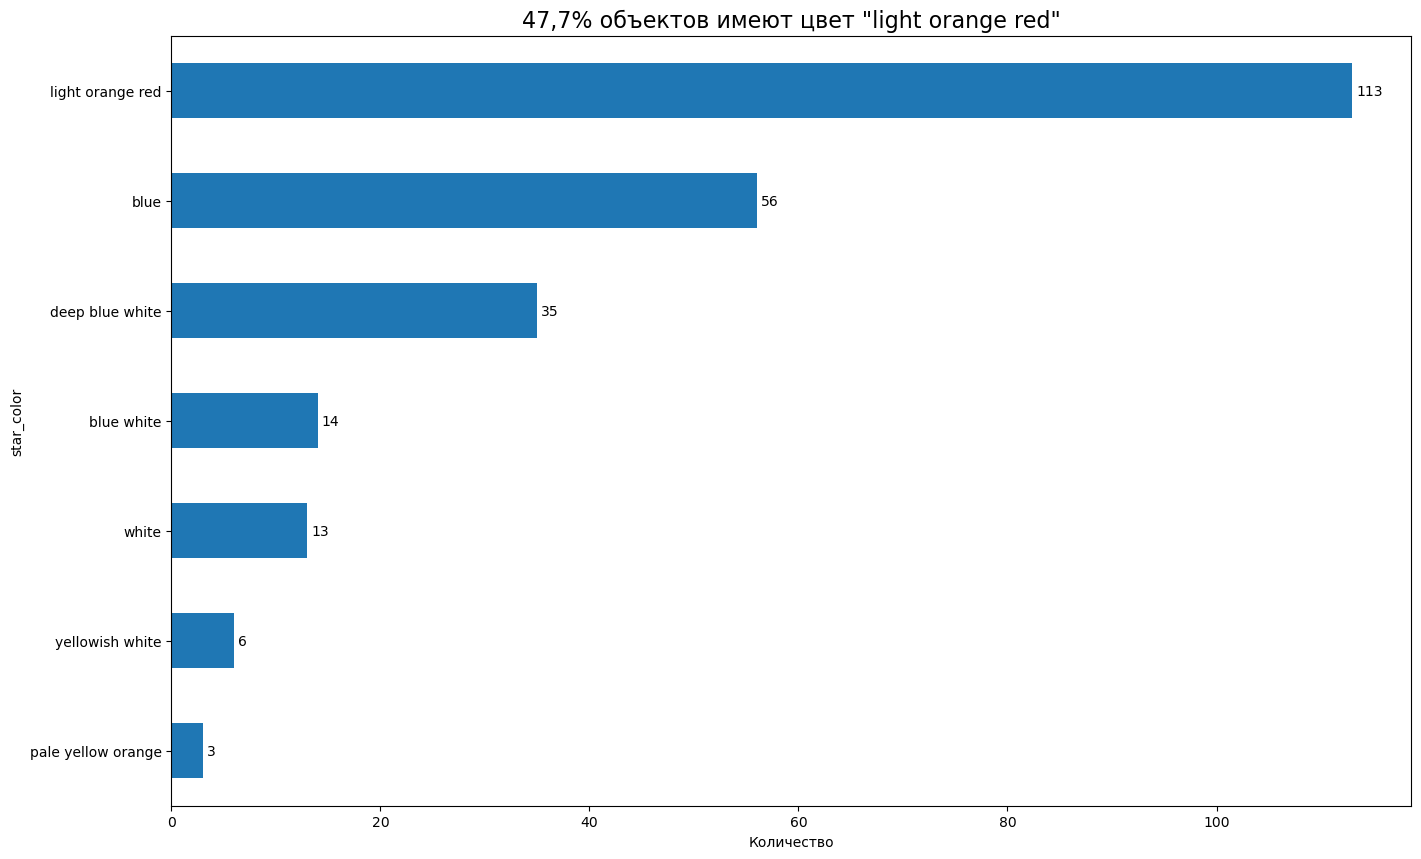

In [20]:
df_star_color = (
    df.groupby('star_color')['temperature']
    .count()
    .sort_values(ascending=True)
)

fig = plt.figure(figsize=(16,10))
ax = df_star_color.plot.barh()
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(3, 0), textcoords='offset points', ha="left", va="center")
plt.title('47,7% объектов имеют цвет "light orange red"', fontsize=16)
plt.ylabel('star_color')
plt.xlabel('Количество')
plt.show()

В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
Количество звезд остальных цветов не превышает 6% для каждого цвета.  

### Числовые признаки
<a id="section_3_3"></a>

Строим гистограммы числовых признаков:

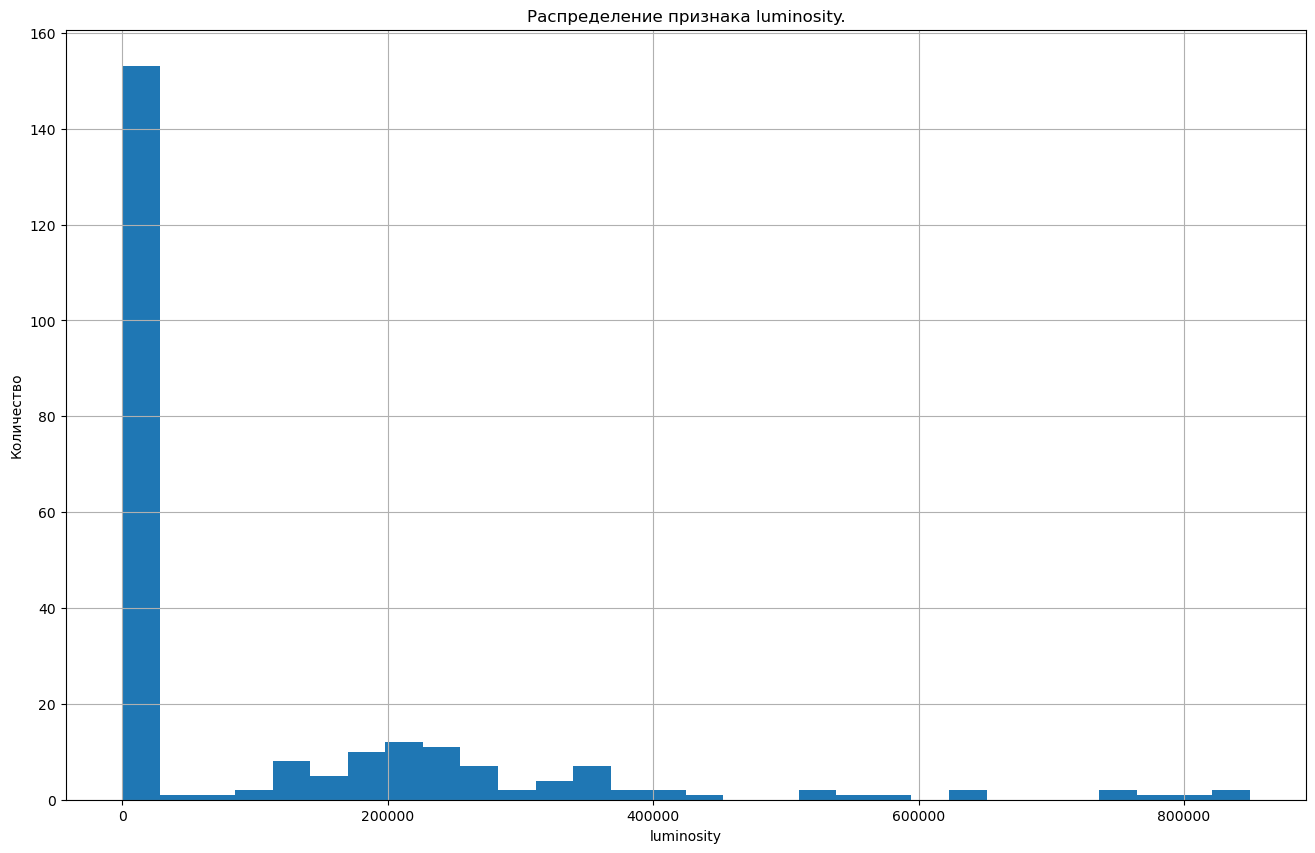

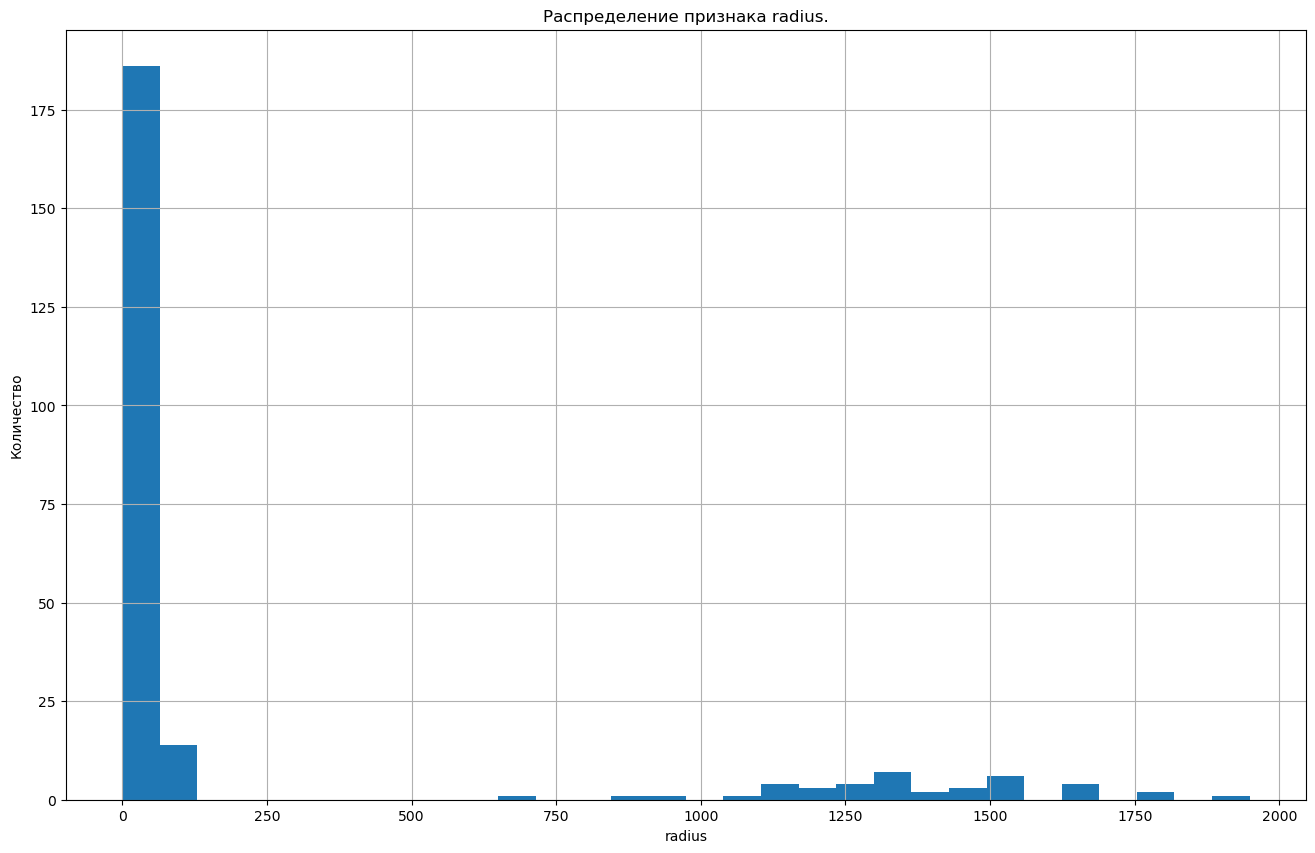

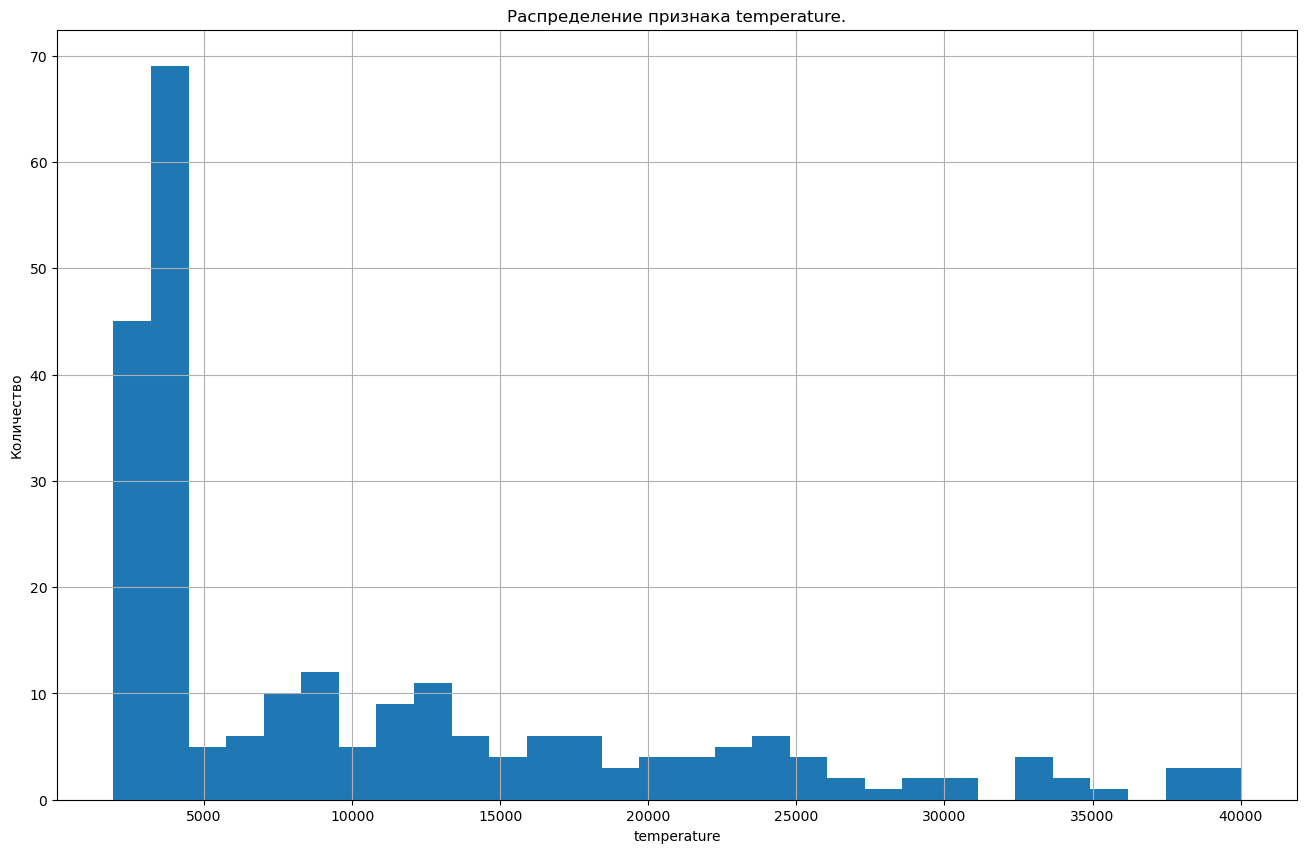

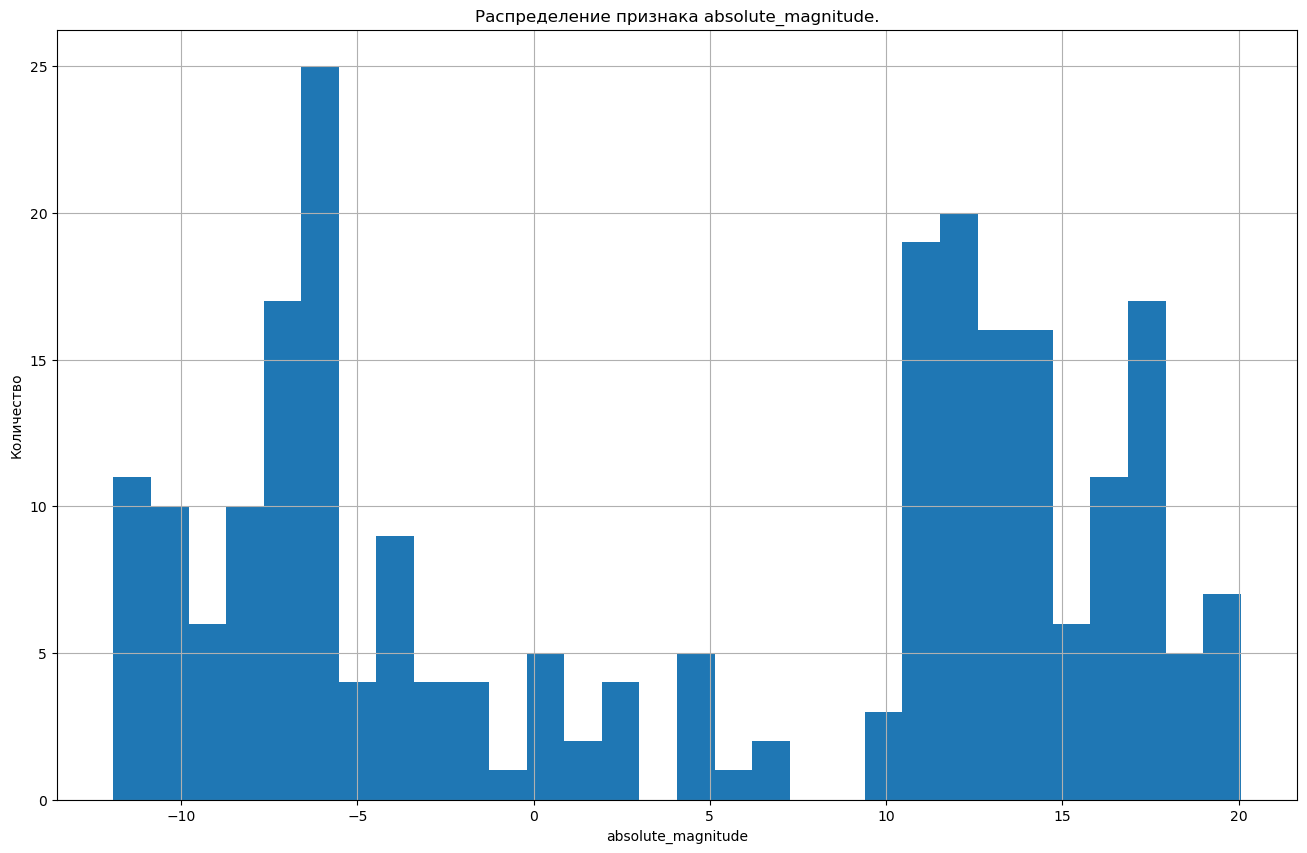

In [21]:
for i in num_list:
    fig = plt.figure(figsize=(16,10))
    df[i].hist(bins=30)
    plt.title('Распределение признака {}.'.format(i))
    plt.ylabel('Количество')
    plt.xlabel(i) 
    plt.show()

Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  

Определим количество звезд больших и меньших, чем Солнце:

In [22]:
def star_size(radius):
    if radius < 1:
        size = 'меньше Солнца'
    elif radius == 0:
        size = 'равно Солнцу'
    else:
        size = 'больше Солнца'
    return size

In [23]:
df['size_class'] = df.apply(lambda x: star_size(x['radius']), axis=1)

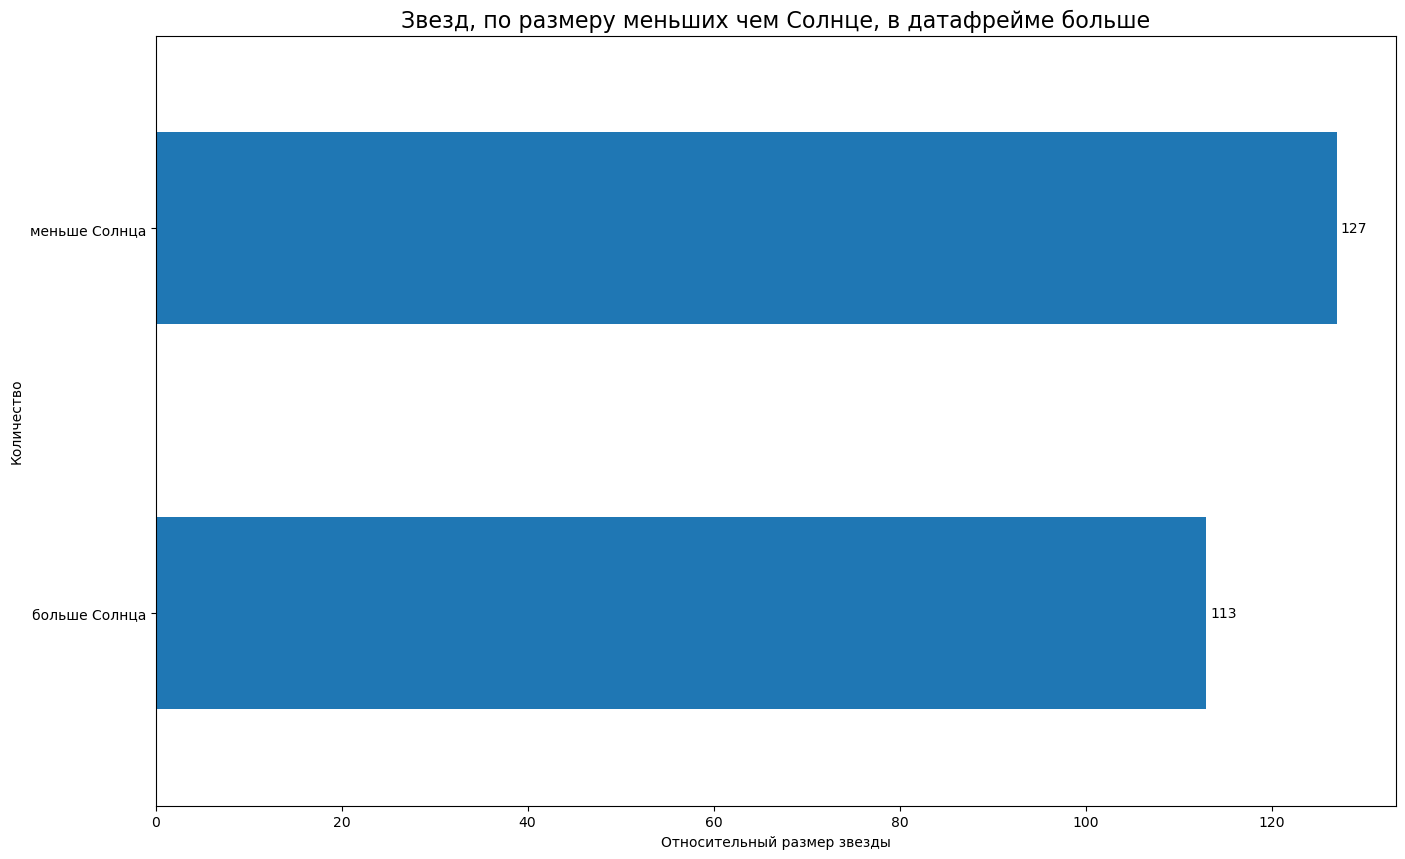

In [24]:
df_star_size = df.groupby('size_class')['temperature'].count()
fig = plt.figure(figsize=(16,10))
ax = df_star_size.plot.barh()
plt.title('Звезд, по размеру меньших чем Солнце, в датафрейме больше', fontsize=16)
plt.ylabel('Количество')
plt.xlabel('Относительный размер звезды')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(3, 0), textcoords='offset points', ha="left", va="center")
plt.show()

Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.

Строим тепловую карту. Во избежание негативного влияния выбросов и нелинейности взаимосвязей признаков для расчёта корреляции применяем коэффициент Спирмена.

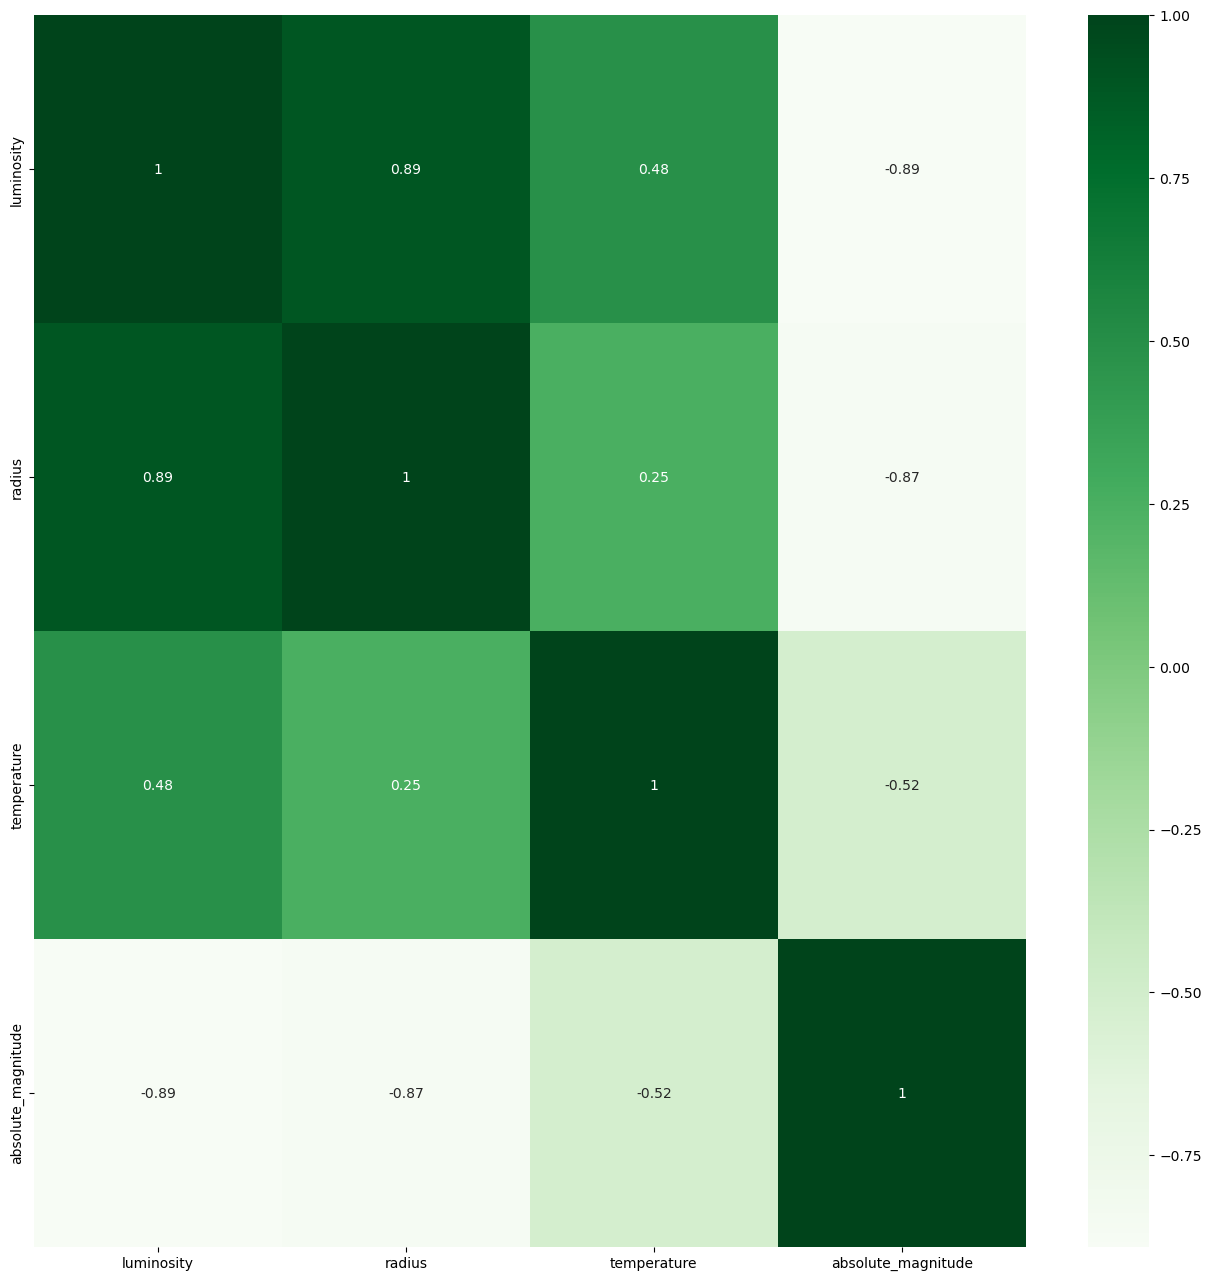

In [25]:
fig = plt.subplots(figsize=(16, 16))
sns.heatmap(df[num_list].corr(method = 'spearman'), annot = True, cmap = 'Greens')
plt.show()

Целевой признак "temperature" имеет значения корреляции с другими признаками:  
- "luminosity": 0.48;
- "radius": 0.25;
- "absolute_magnitude": -0.52.

Наибольшая корреляция между "luminosity" и "radius": 0.89.
Высокая обратная корреляция между:
- "luminosity" и "absolute_magnitude": -0.89;
- "radius" и "absolute_magnitude": -0.87.

Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.

Рассчитываем среднее значение и стандартное отклонение целевого признака "temperature":

In [26]:
print('Среднее значение - {:.1f} K.'.format(df['temperature'].mean()))
print('Стандартное отклонение - {:.1f} K.'.format(df['temperature'].std()))

Среднее значение - 10497.5 K.
Стандартное отклонение - 9552.4 K.


**Вывод:**  
1. По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).  
2. В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
   Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
   Количество звезд остальных цветов не превышает 6% для каждого цвета.  
3. Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
    Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  
4. Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.
5. Целевой признак "temperature" имеет значения корреляции с другими признаками:  

    - "luminosity": 0.48;
    - "radius": 0.25;
    - "absolute_magnitude": -0.52.

 Наибольшая корреляция между "luminosity" и "radius": 0.89.
    Высокая обратная корреляция между:
    - "luminosity" и "absolute_magnitude": -0.89;
    - "radius" и "absolute_magnitude": -0.87.

   Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.
6. Среднее значение целевого признака "temperature" - 10497.5 K.  
    Стандартное отклонение целевого признака "temperature" - 9552.4 K.

## Подготовка данных к построению нейросети
<a id="section_4"></a>

Задаем параметр "random_state":

In [27]:
RS = np.random.RandomState(5)

Создаем списки категориальных, числовых признаков и выделяем целевой признак:

In [28]:
cat_features = ['star_type', 'star_color']
num_features = ['luminosity', 'radius', 'absolute_magnitude']
target_param = 'temperature'

Создаем датафрейм признаков и вектор целевого признака:

In [29]:
features = df.drop(['temperature', 'size_class'], axis=1)
target = df[target_param]

Разделяем выборку на обучающую и тестовую:

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, shuffle=True, random_state=RS)
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

**Масштабирование числовых и кодирование (OHE) категориальных значений**

Класс масштабирования числовых значений:

In [31]:
class ScalerTransformation(BaseEstimator, TransformerMixin): 
    scaler = StandardScaler()
    
    def fit(self, X, y=None):
        X = X.copy()                                               # делаем копию матрицы признаков
        self.scaler.fit(X[num_features])                           # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                               # делаем копию матрицы признаков
#         X = X.reset_index(drop=True)
        X[num_features] = self.scaler.transform(X[num_features])   # масштабируем числовые значения
        return X

Класс кодирования (OHE) категориальных значений:

In [32]:
class OheTransform(BaseEstimator, TransformerMixin): 
    encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
    
    def fit(self, X, y=None):
        X = X.copy()                              # делаем копию матрицы признаков
        self.encoder.fit(X[cat_features])         # обучаем encoder на категориальных данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                                         # делаем копию матрицы признаков
        feature_arr = self.encoder.transform(X[cat_features]).toarray()      # кодируем категориальные значения
        ohe_labels = self.encoder.get_feature_names_out(cat_features)        # создаем список названий новых признаков
        features = pd.DataFrame(                                             # собираем результаты в датафрейм
               feature_arr,
               columns=ohe_labels)
        X = X.join(features)                                                 # добавляем результаты кодирования в исходную таблицу
        X = X.drop(cat_features, axis=1)                                     # удаляем исходные категориальные столбцы
        X.columns = map(str.lower, X.columns)                                # переводим названия столбцов в нижний регистр
        
        return X

Создаем и обучаем pipeline:

In [33]:
pipe = make_pipeline(ScalerTransformation(), OheTransform())
pipe.fit(features_train)

Pipeline(steps=[('scalertransformation', ScalerTransformation()),
                ('ohetransform', OheTransform())])

Преобразовываем обучающую и тестовую выборки:

In [34]:
features_train = pipe.transform(features_train)
features_test = pipe.transform(features_test)

Выводим 5 случайных строк обучающей выборки:

In [35]:
features_train.sample(n=5)

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_deep blue white,star_color_light orange red,star_color_pale yellow orange,star_color_white,star_color_yellowish white
96,-0.572267,-0.431892,1.167640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
105,-0.572267,-0.431907,1.083487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.420229,-0.419572,-0.884192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,-0.565780,-0.417639,-0.658207,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
129,3.702034,1.835914,-1.197167,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Выводим 5 случайных строк тестовой выборки:

In [36]:
features_test.sample(n=5)

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_deep blue white,star_color_light orange red,star_color_pale yellow orange,star_color_white,star_color_yellowish white
5,0.861085,-0.359835,-1.062427,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2.497122,2.423990,-1.486504,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
59,-0.564969,-0.420690,-0.785855,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.398529,3.138512,-1.408023,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
42,-0.572267,-0.432070,0.870739,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Вывод:**  
1. Выборка разделена на обучающую и тестовую.
2. Произведено масштабирование числовых и кодирование (OHE) категориальных значений обучающей и тестовой выборки.

## Построение базовой нейронной сети
<a id="section_5"></a>

Создаем класс структуры нейросети. В классе 2 скрытых слоя. Функция активации - LeakyReLU, инициализация весов признаков - нормальным распределением.

In [37]:
class Net(nn.Module):
    '''Класс структуры нейросети'''
    
    # функция, задающая структуру нейросети
    def __init__(self, n_in_neurons=features_train.shape[1], n_hidden_neurons_1=32, n_hidden_neurons_2=64, n_out_neurons=1, activation_1=nn.ReLU(), activation_2=nn.ReLU(), activation_3=nn.ReLU(), dropout_1=0, dropout_2=0, batch_1=0, batch_2=0):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = activation_1
            if batch_1 == 1:
                self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.dp1 = nn.Dropout(p=dropout_1)
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = activation_2
            if batch_2 == 1:
                self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.dp2 = nn.Dropout(p=dropout_2)
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = activation_3
            
            self.flatten = nn.Flatten(start_dim=0)
    
            
            # инициируем веса признаков
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc1.bias, a=-((6/n_in_neurons)**0.5), b=((6/n_in_neurons)**0.5))
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc2.bias, a=-((6/n_hidden_neurons_1)**0.5), b=((6/n_hidden_neurons_1)**0.5))
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc3.bias, a=-((6/n_hidden_neurons_2)**0.5), b=((6/n_hidden_neurons_2)**0.5))
     
    # функция активирующая нейросеть
    def forward(self, x, dropout=0, batch=0):
        x = self.fc1(x)
        x = self.act1(x)
        if batch == 1:
            x = self.bn1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        if batch == 1:
            x = self.bn2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return self.flatten(x)

Переводим матрицы и векторы признаков в тензоры:

In [38]:
features_train = torch.FloatTensor(np.array(features_train))    # переводим матрицу признаков обучающей выборки в тензор
features_test = torch.FloatTensor(np.array(features_test))    # переводим матрицу признаков тестовой выборки в тензор
target_train = torch.FloatTensor(np.array(target_train))        # переводим вектор целевого признака обучающей выборки в тензор
target_test = torch.FloatTensor(np.array(target_test))          # переводим вектор целевого признака тестовой выборки в тензор

Создаем функцию рассчета метрики RMSE:

In [39]:
def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

Инициализируем модель NeuralNetRegressor:

In [40]:
skorch_regressor = NeuralNetRegressor(module=Net, 
                                      device='cpu',  
                                      verbose=0,
                                      batch_size=32,
                                      max_epochs=20000, 
                                      train_split=ValidSplit(cv=5),
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=make_scorer(rmse_scorer), lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=100)),
            ],
                                     ) 

Рассчитываем RMSE для базовой нейросети:

In [41]:
skorch_regressor.fit(features_train, target_train)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=14, out_features=32, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (act3): ReLU()
    (flatten): Flatten(start_dim=0, end_dim=-1)
  ),
)

In [42]:
default_pred = skorch_regressor.predict(features_train)
rmse_default = mean_squared_error(target_train, default_pred, squared=False)
print('RMSE базовой нейросети: {:.3f}'.format(rmse_default))

RMSE базовой нейросети: 14863.047


## Улучшение нейронной сети
<a id="section_6"></a>

Задаем сетку подбора гмперпараметров:

In [43]:
params = {
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'module__n_in_neurons': [features_train.shape[1]],
    'module__n_hidden_neurons_1': [64, 128, 256, 512, 1024, 2048],
    'module__n_hidden_neurons_2': [8, 16, 32, 64, 128, 256],
    'module__n_out_neurons': [1],
    'module__activation_1': [nn.LeakyReLU(), nn.ReLU(), nn.ELU()],
    'module__activation_2': [nn.LeakyReLU(), nn.ReLU(), nn.ELU()],
    'module__activation_3': [nn.LeakyReLU(), nn.ReLU(), nn.ELU()],
    'module__dropout_1': [0, 0.3, 0.5],
    'module__dropout_2': [0, 0.3, 0.5],
    'module__batch_1': [0, 1],
    'module__batch_2': [0, 1],
    'lr': [1e-3, 1e-4, 1e-5],
    'criterion': [nn.MSELoss, nn.L1Loss]
}

Обучаем модель:

In [44]:
model = RandomizedSearchCV(skorch_regressor, params, cv=5, scoring="neg_root_mean_squared_error", verbose=0) 
model.fit(features_train, target_train)

C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\bond_\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selectio

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=14, out_features=32, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0, inplace=False)
    (fc3): Linear(in_features=64, out_features=1, bias=...
                                        'module__dropout_1': [0, 0.3, 0.5],
                                        'module__dropout_2': [0, 0.3, 0.5],
                                        'module__n_hidden_neurons_1': [64, 128,
                                                                       256, 512,
                                                                       1024,
                                                                       2048],
                                        'module__n_hidden_neurons_2': [8, 16,
                                                                       32, 64,
                                                                       128,
                                                                       256],
                                        'module__n_in_neurons': [14],
                                        'module__n_out_neurons': [1],
                                        'optimizer': [<class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.rmsprop.RMSprop'>]},
                   scoring='neg_root_mean_squared_error')

In [45]:
print('RMSE на обучающей выборке при кросс-валидации: {:.3f}'.format(abs(model.best_score_)))

RMSE на обучающей выборке при кросс-валидации: 4994.681


Параметры лучшей модели:

In [46]:
model.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__n_out_neurons': 1,
 'module__n_in_neurons': 14,
 'module__n_hidden_neurons_2': 256,
 'module__n_hidden_neurons_1': 1024,
 'module__dropout_2': 0.5,
 'module__dropout_1': 0,
 'module__batch_2': 1,
 'module__batch_1': 1,
 'module__activation_3': ReLU(),
 'module__activation_2': ELU(alpha=1.0),
 'module__activation_1': ELU(alpha=1.0),
 'lr': 0.001,
 'criterion': torch.nn.modules.loss.MSELoss}

## Проверка на тестовой выборке
<a id="section_7"></a>

Наилучший результат на тестовой выборке:

In [47]:
y_pred = model.predict(features_test)
rmse_test = mean_squared_error(target_test, y_pred, squared=False)
print('RMSE на тестовой выборке: {:.3f}'.format(rmse_test))

RMSE на тестовой выборке: 4310.033


Строим гистограмму распределения реальных и предсказанных температур:

In [48]:
def comparison_hist(test_preds, target_test):
    '''Функция визуализации качества нейросети (Факт — прогноз)'''
    
    y1 = test_preds
    y2 = target_test.detach().numpy().reshape([-1])     # преобразуем тензор тестовых фактических целевых признаков в одномерный список в тензор
    x = np.arange(len(y1))                              # получаем массив с индексами предсказаний

    fig,ax = plt.subplots(figsize=(16, 12))             # создаем поле графика
    ax.set_xticks(x)                                    # Задаем количество делений по оси x
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')      # выводим на график данные по фактическим значениям
    pred = ax.bar(x, y1, width = 0.3, label = 'Прогноз')   # выводим на график данные по предсказанным значениям
    ax.legend()                                            # добавляем легенду
    ax.set_title('График "факт-прогноз"', fontsize=20)     # добавляем заголовок
    ax.set_xlabel('Индекс звезды')                         # добавляем подпись оси x
    ax.set_ylabel('Температура')                           # добавляем подпись оси y
    plt.show()

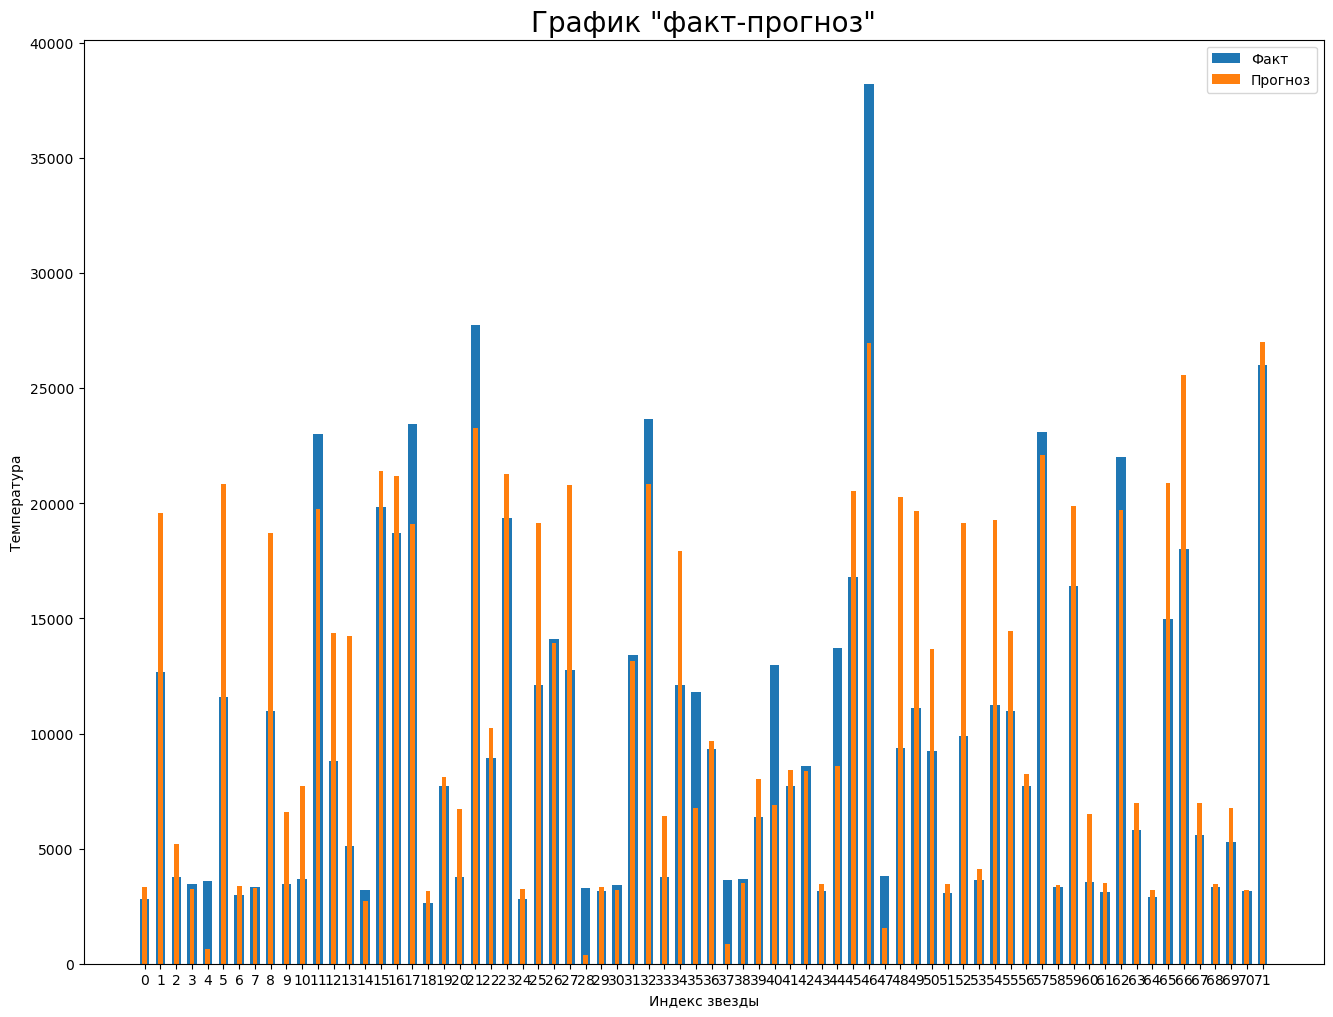

In [49]:
comparison_hist(y_pred, target_test)

## Общий вывод
<a id="section_8"></a>

**Загрузка данных и общая информация**  

1. В датафрейме 240 строк и 7 признаков. Признак "Unnamed: 0" - лишний: дублирует индексы датафрейма.
2. Пропущенные значения отсутствуют.  
3. Следующие признаки имеют тип int64:  
 - Unnamed: 0;  
 - Temperature (K);  
 - Star type.  
 
 Следующие признаки имеют тип object:  
  - Star color.   

 Следующие признаки имеют тип float64:  
  - Luminosity(L/Lo);   
  - Radius(R/Ro);   
  - Absolute magnitude(Mv).   
  
  
4. Уникальные значения признака "Star color" не в полной мере соответствуют <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>: вперемешку идет классификация по обычному описанию цвета и фактически видимому цвету.  
5. Максимальное значение признака "Temperature (K)" в 2.65 раз выше значения третьего квартиля.
6. Максимальное значение признака "Luminosity(L/Lo)" в 4.29 раз выше значения третьего квартиля.
7. Максимальное значение признака "Radius(R/Ro)" в 45.58 раз выше значения третьего квартиля.  
8. Максимальное значение признака "Absolute magnitude(Mv)" в 1.46 раз выше значения третьего квартиля.


**Предобработка данных**  

1. Названия признаков приведены в соответствие с требованиями PEP 8.
2. Обнаружен 1 объект с аномальным значением признака. Но из исследования он не исключен.
3. Значения признака "star_color" приведены к единой форме. Устранены разночтения в классификации объектов по данному признаку. Количество уникальных значений сокращено с 19 до 7. 


**Исследовательский анализ данных**  

1. По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).  
2. В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
   Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
   Количество звезд остальных цветов не превышает 6% для каждого цвета.  
3. Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
    Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  
4. Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.
5. Целевой признак "temperature" имеет значения корреляции с другими признаками:

    - "luminosity": 0.48;
    - "radius": 0.25;
    - "absolute_magnitude": -0.52.

    Наибольшая корреляция между "luminosity" и "radius": 0.89.
    Высокая обратная корреляция между:
    - "luminosity" и "absolute_magnitude": -0.89;
    - "radius" и "absolute_magnitude": -0.87.

   Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.  
6. Среднее значение целевого признака "temperature" - 10497.5 K.  
   Стандартное отклонение целевого признака "temperature" - 9552.4 K.
   

**Подготовка данных к построению нейросети**  

1. Выборка разделена на обучающую и тестовую.
2. Произведено масштабирование числовых и кодирование (OHE) категориальных значений обучающей и тестовой выборки.  


**Построение базовой нейронной сети**  

RMSE базовой модели - 14863.047.  


**Улучшение нейронной сети**  

Построенная базовая нейронная сеть. RMSE на обучающей выборке при кросс-валидации - 5204.336.

Гмперпараметры модели с наименьшим значением RMSE и результаты приведены ниже:  
 - optimizer: torch.optim.sgd.SGD;
 - n_out_neurons: 1;
 - n_in_neurons: 14;
 - n_hidden_neurons_2: 256;
 - n_hidden_neurons_1: 1024;
 - dropout_2: 0.5;
 - dropout_1: 0.0;
 - batch_2: 1;
 - batch_1: 1;
 - activation_3: ReLU();
 - activation_2: ELU(alpha=1.0);
 - activation_1: ELU(alpha=1.0);
 - lr': 0.001;
 - criterion: torch.nn.modules.loss.MSELoss.  


**Проверка на тестовой выборке**  

RMSE на тестовой выборке - 4310.033.